# Scores voor vakken voorspellen

We geven een lijst van studenten aan een docent en vragen hoe hij/zij deze studenten inschat.
De docent mag aan iedere student een score toekennen volgens zijn gevoel (niet volgens punten).
We verwachten dat een docent dit onbewust toch zal doen op basis van zijn eigen vakken.


1. Lees het bestand "studentenScores.csv" in.  Hierin zie je de subjectieve scores, gegeven door de docent.  De score kan zijn: "goed", "gemiddeld", "slecht".  We vragen ons nu af op basis van welke criteria de docent zijn scores heeft gegeven.

In [69]:
import numpy as np
import pandas as pd

studentenScores = pd.read_csv('data/studentenScores.csv')
# Maak categorieën van de.Nominale waardes in tabel score.
studentenScores.score = studentenScores.score.astype(pd.CategoricalDtype(categories=['slecht', 'gemiddeld', 'goed'], ordered=True))
display(studentenScores)

,vak1,vak2,vak3,vak4,vak5,vak6,vak7,vak8,vak9,score
0,13,9,17,2,17,1,0,14,18,gemiddeld
1,10,13,5,20,20,14,4,2,10,goed
2,13,4,2,19,3,9,16,13,7,goed
3,8,3,17,7,16,10,15,9,8,slecht
4,1,12,13,2,9,10,2,2,13,slecht
...,...,...,...,...,...,...,...,...,...,...
95,14,10,15,4,4,6,10,13,8,gemiddeld
96,16,10,16,1,8,11,19,0,13,gemiddeld
97,0,20,9,7,13,11,18,10,9,slecht
98,14,15,16,9,4,8,10,18,9,gemiddeld


2. Stel daartoe een beslissingsboom op voor de score.

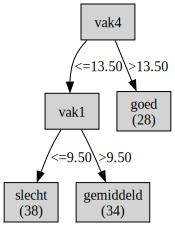

In [70]:
import graphviz
from id3 import Id3Estimator, export_graphviz

X = studentenScores.drop(columns=['score'], axis=1)
y = studentenScores['score']

model = Id3Estimator()

# Bouw het model
model.fit(X, y)

# maak model
model_tree = export_graphviz(model.tree_, feature_names=X.columns)
# toon beslissingsboom
graphviz.Source(model_tree.dot_tree)

3. Welke vakken geeft de docent?

In [71]:
from scipy.stats import chi2_contingency

# Bereken Cramers V-statistiek voor elke combinatie van kolommen.
cols = studentenScores.columns.tolist()
corr_matrix = pd.DataFrame(index=cols, columns=cols)
for col1 in cols:
    for col2 in cols:
        if col1 == col2:
            corr_matrix.loc[col1, col2] = 1.0
        else:
            crosstab = pd.crosstab(studentenScores[col1], studentenScores[col2])
            chi2, p, dof, expected = chi2_contingency(crosstab)
            n = crosstab.sum().sum()
            phi2 = chi2/n
            r,k = crosstab.shape
            phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
            rcorr = r - ((r-1)**2)/(n-1)
            kcorr = k - ((k-1)**2)/(n-1)
            corr_matrix.loc[col1, col2] = np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))
display(corr_matrix.score)

# Vakken 1 en 4 hebben de hoogste correlatie.
# Dit is een overbodige, complexe manier. Voor de correlatie te berekenen van nominale waardes, maar voor een rare reden wouwen mijn categorieën niet werken. DUS...

vak1     0.533417
vak2          0.0
vak3          0.0
vak4     0.639122
vak5     0.132951
vak6          0.0
vak7     0.131302
vak8      0.11753
vak9     0.181706
score         1.0
Name: score, dtype: object

4. De boomstructuur is nogal complex.

Dat komt omdat de punten veel waarden kunnen aannemen.
We kunnen dit oplossen door de punten op te delen in categorieën:
 * niet geslaagd (0-9),
 * voldoening (10-13),
 * onderscheiding (14-15),
 * grote onderscheiding (16-20).

Probeer de scores zo in te delen.


In [72]:
grades_cat = studentenScores.drop('score', axis=1).apply(pd.cut, bins=[0, 10, 14, 16, 21], right=False, labels=['niet geslaagd', 'voldoening', 'onderscheiding', 'grote onderscheiding'])
grades_cat['score'] = studentenScores.score

5. Bereken nu de boomstructuur opnieuw.  Is dit duidelijker?

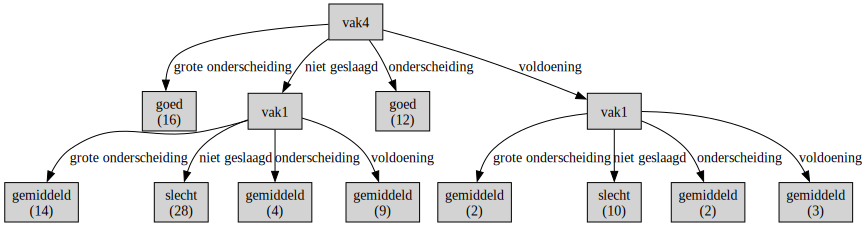

In [73]:
from id3.export import DotTree

model = Id3Estimator()
X = grades_cat.drop(['score'], axis=1).values.tolist()
y = grades_cat['score'].values.tolist()
model.fit(X, y)

model_tree = DotTree()
_ = export_graphviz(model.tree_, model_tree, feature_names=grades_cat.drop(columns=['score']).columns)
graph = graphviz.Source(model_tree.dot_tree)
graph
# Ja

6. Hoe zou de docent iemand inschatten als die volgende punten heeft: 9, 14, 13, 12, 15, 13, 7, 10, 18

In [77]:
scores = pd.cut([9, 14, 13, 12, 15, 13, 7, 10, 18], bins=[0, 10, 14, 16, 21], right=False, labels=['niet geslaagd', 'voldoening', 'onderscheiding', 'grote onderscheiding'])
print(model.predict([scores])) # slecht

['slecht']


7. Maak eens een boomstructuur met het C4.5 algoritme en een ScitKit DecisionTree op de originele gegevens en kijk welk resultaat daar uit komt.

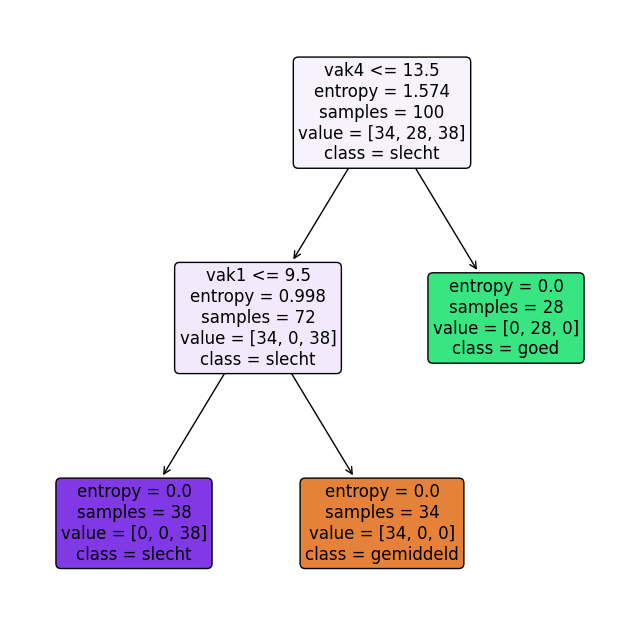

In [75]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import matplotlib.pyplot as plt

classifier = DecisionTreeClassifier(criterion='entropy')
X = studentenScores.drop(columns=['score'])
y = studentenScores.score
classifier.fit(X, y)

fig, ax = plt.subplots(figsize=(8, 8))
_ = tree.plot_tree(classifier, ax=ax, feature_names=X.columns.values, class_names=['{}'.format(i) for i in np.unique(y)], filled=True, fontsize=12, rounded=True)

8. Maak eens een boomstructuur met een ScitKit DecisionTree op de onehot encoded gegevens (gebruik Pandas `get_dummies`) en kijk welk resultaat daar uit komt.

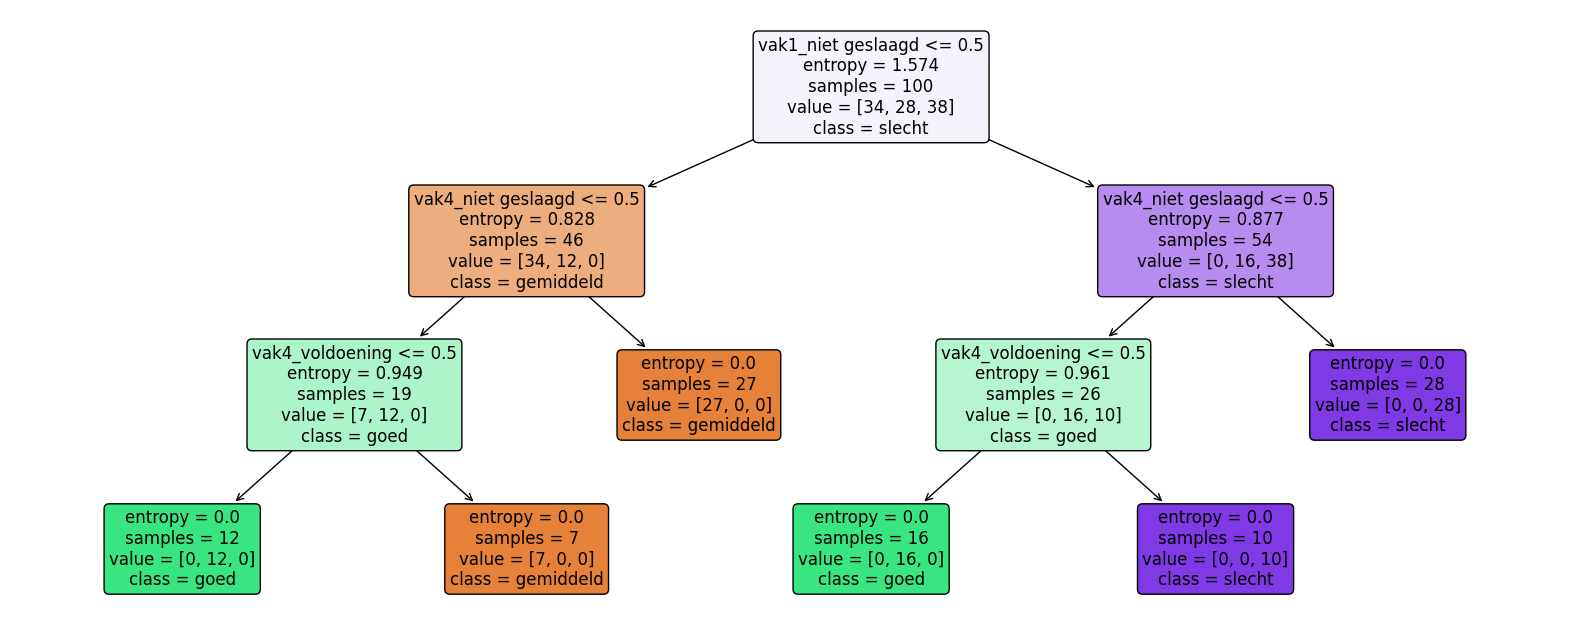

In [76]:
from sklearn import tree
import matplotlib.pyplot as plt

X = pd.get_dummies(grades_cat.drop(columns=['score']))
y = studentenScores.score
classifier.fit(X, y)

fig, ax = plt.subplots(figsize=(20, 8))
_ = tree.plot_tree(classifier, ax=ax, feature_names=X.columns.values, class_names=['{}'.format(i) for i in np.unique(y)], filled=True, fontsize=12, rounded=True)